<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/GST/notebooks/Intuition_of_Geometric_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Sample

In [1]:
!wget -q https://www.dropbox.com/s/z2jijn8qp7xst8l/IMG_0203.jpg -O cat1.jpg
!wget -q https://www.dropbox.com/s/869hzklub0ahtra/IMG_0204.jpg -O cat2.jpg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
def imshow(img):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
cat1 = cv2.cvtColor(cv2.imread("cat1.jpg"), cv2.COLOR_BGR2RGB)
cat2 = cv2.cvtColor(cv2.imread("cat2.jpg"), cv2.COLOR_BGR2RGB)

print(f"cat1 shape: {cat1.shape}")
print(f"cat2 shape: {cat2.shape}")

cat1 shape: (3264, 2448, 3)
cat2 shape: (3264, 2448, 3)


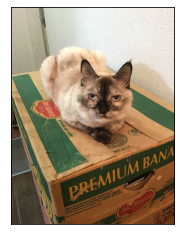

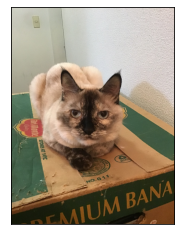

In [5]:
imshow(cat1)
imshow(cat2)

## Affine Transform

$$\left(\begin{array}{l}
x^{\prime} \\
y^{\prime} \\
1
\end{array}\right)=\left(\begin{array}{lll}
a & b & t_{x} \\
c & d & t_{y} \\
0 & 0 & 1
\end{array}\right)\left(\begin{array}{l}
x \\
y \\
1
\end{array}\right)$$

OpenCV3's API of Affine Transform

```python
cv2.warpAffine(
    src,           # ndarray src image
    M,             # convert Matrix [2x3]
    dsize,         # tuple of image size (W, H)
    [dst],         # background image
    [flags],       # interpolation
                   # (INTER_NEAREST, INTER_LINEAR)
                   # (INTER_CUBIC, INTER_LANCZOS4) 
    [borderMode],  # (BORDER_CONSTANT, BORDER_REPLICATE,
                   #  BORDER_REFLECT, ...)
    [borderValue]  # (BGR)
)
```

In [6]:
# img shape
h, w, c = cat1.shape

# vertical moving matrix
mat = np.array([
    [1, 0, 0],
    [0, 1, 300]
], dtype=np.float32)

In [7]:
cat1_affine = cv2.warpAffine(cat1, mat, (w, h))

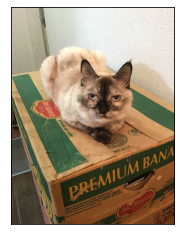

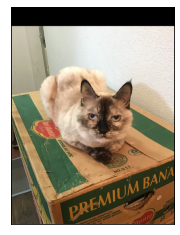

In [8]:
imshow(cat1)
imshow(cat1_affine)

## Affine Transform by Pure PyTorch

### [torch.nn.functional.affine_grid(theta, size, align_corners=None)](https://pytorch.org/docs/stable/nn.functional.html#affine-grid)

この関数はアフィン変換専用の関数であり、変換後のグリッド表現を取得できる。

#### Purpose

Generates a 2D or 3D flow field (sampling grid), given a batch of affine matrices theta

#### Parameters
- `theta (Tensor)`: input batch of affine matrices with shape (N x 2 x 3) for 2D or (N x 3 x 4) for 3D
- `size (torch.Size)`: the target output image size. (N x C x H x W) for 2D or (N x C x D x H x W)
- `align_corners (bool)`: if True, consider -1 and 1 to refer to the centers of the corner pixels rather than the image corners. Refer to grid_sample() for a more complete description. A grid generated by affine_grid() should be passed to grid_sample() with the same setting for this option. Default: False

#### Returns

output Tensor of size (N x H x W x 2)



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T

In [10]:
cat1_tensor = T.ToTensor()(cat1).unsqueeze(0)
cat2_tensor = T.ToTensor()(cat2).unsqueeze(0)

print(cat1_tensor.shape)
print(cat1_tensor.dtype)
print(cat1_tensor.min(), cat1_tensor.max())

torch.Size([1, 3, 3264, 2448])
torch.float32
tensor(0.) tensor(1.)


In [11]:
# grid range [-1, 1]
affine_metrices = torch.tensor([[
    [1, 0, 0],
    [0, 1, -0.3]
]], dtype=torch.float, requires_grad=True)

print(affine_metrices.shape)
print(affine_metrices.dtype)

torch.Size([1, 2, 3])
torch.float32


In [12]:
affine_grid = F.affine_grid(affine_metrices, cat1_tensor.shape)

print(affine_grid.shape)
print(affine_grid.dtype)

torch.Size([1, 3264, 2448, 2])
torch.float32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [13]:
# grid X position after affine translation
affine_grid[..., 0]

tensor([[[-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         ...,
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996],
         [-0.9996, -0.9988, -0.9980,  ...,  0.9980,  0.9988,  0.9996]]],
       grad_fn=<SelectBackward>)

In [14]:
# grid Y position after affine translation
affine_grid[..., 1]

tensor([[[-1.2997, -1.2997, -1.2997,  ..., -1.2997, -1.2997, -1.2997],
         [-1.2991, -1.2991, -1.2991,  ..., -1.2991, -1.2991, -1.2991],
         [-1.2985, -1.2985, -1.2985,  ..., -1.2985, -1.2985, -1.2985],
         ...,
         [ 0.6985,  0.6985,  0.6985,  ...,  0.6985,  0.6985,  0.6985],
         [ 0.6991,  0.6991,  0.6991,  ...,  0.6991,  0.6991,  0.6991],
         [ 0.6997,  0.6997,  0.6997,  ...,  0.6997,  0.6997,  0.6997]]],
       grad_fn=<SelectBackward>)

### [torch.nn.functional.grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=None)](https://pytorch.org/docs/stable/nn.functional.html#grid-sample)

#### Purpose

入力テンソルと変換後のグリッドの位置情報から、出力テンソルを計算する。

変換前後で位置が一致していない値に関しては、補間計算を行っている。その際に補間を行う手法を選択することが可能である。

入力するグリッドは、入力テンソルの空間次元に合わせて−1から1までの値で正規化されている。もしもグリッドの値が-1から1までの範囲外にあるときは、`padding_mode`によって計算される。

#### Parameters

- `input (Tensor)`: input of shape (N, C, H_in, W_in) (4-D case) or (N, C, D_in, H_in, W_in) (5-D case)
- `grid (Tensor)`: flow-field of shape (N, H_out, W_out, 2) (4-D case) or (N, D_out, H_out, W_out, 3) (5-D case)
- `mode (str)`: interpolation mode to calculate output values `bilinear` | `nearest`. Default: `bilinear`
- `padding_mode (str)`: padding mode for outside grid values `zeros` | `border` | `reflection`. Default: `zeros`
- `align_corners (bool, optional)`: Geometrically, we consider the pixels of the input as squares rather than points. If set to True, the extrema (-1 and 1) are considered as referring to the center points of the input’s corner pixels. If set to False, they are instead considered as referring to the corner points of the input’s corner pixels, making the sampling more resolution agnostic. This option parallels the align_corners option in interpolate(), and so whichever option is used here should also be used there to resize the input image before grid sampling. Default: False

#### Returns

output Tensor

In [15]:
cat1_tensor_affine = F.grid_sample(cat1_tensor, 
                                   affine_grid,
                                   mode="bilinear")
cat1_tensor
print(cat1_tensor_affine.shape)
print(cat1_tensor_affine.dtype)
print(cat1_tensor_affine.min(), cat1_tensor_affine.max())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


torch.Size([1, 3, 3264, 2448])
torch.float32
tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


In [16]:
def imshow_tensor(img_tensor):
    r"""
    img_tensor (torch.Tensor): the image tensor of shape [C x H x W]
    """

    if img_tensor.max() <= 1.:
        img_tensor = img_tensor * 255
    img = img_tensor.permute(1, 2, 0).to(dtype=torch.uint8).cpu().numpy()
    imshow(img)

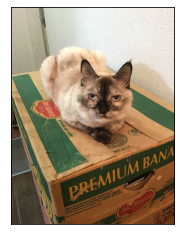

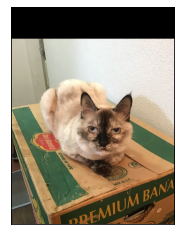

In [17]:
imshow_tensor(cat1_tensor[0]*255)
imshow_tensor(cat1_tensor_affine[0]*255)

## Spatial Transformer Network

Gemetric Style Transferでは、アフィン変換などのパラメータをCNNを通して学習させている。

そこで同じくパラメータを推定して画像分類に適用したSpatial Transformer Networkの構造を考える。

- `localization network`では、アフィン変換などのパラメータを推定するネットワークを通常のCNNに組み込んだモデルである。本モデルでは、教師なしでこうしたパラメータを学習させていく。
- `grid generator`では、入力テンソルとアフィン変換のパラメータから、変換後のピクセル位置を示すグリッドテンソルを取得する。
- `sampler`では、得られたグリッドテンソルを元に入力テンソルの各空間の位置を変換する。

![](https://brsoff.github.io/tutorials/_images/stn-arch.png)

[[arXiv:1506.02025] Spatial Transformer Networks](https://arxiv.org/abs/1506.02025)

[[PyTorch Official Implementation] DEPICTING SPATIAL TRANSFORMER NETWORKS](https://brsoff.github.io/tutorials/intermediate/spatial_transformer_tutorial.html#depicting-spatial-transformer-networks)

In [18]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
class AffineNet(nn.Module):
    def __init__(self, mode='bilinear'):
        super().__init__()
        self.mode = mode

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(20, 30, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(30, 40, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(40 * 14 * 14, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 40 * 14 * 14)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid, mode=self.mode)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        return x

In [20]:
model = AffineNet(mode="nearest")

In [21]:
apply_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [22]:
cat1_tensor = apply_transforms(Image.fromarray(cat1)).unsqueeze(0)
cat2_tensor = apply_transforms(Image.fromarray(cat2)).unsqueeze(0)

print(cat1_tensor.shape)
print(cat1_tensor.dtype)
print(cat1_tensor.min(), cat1_tensor.max())

torch.Size([1, 3, 224, 224])
torch.float32
tensor(0.0039) tensor(1.)


In [23]:
# identity transform before training
cat1_tensor_output = model(cat1_tensor)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


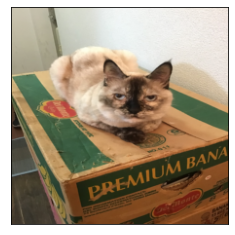

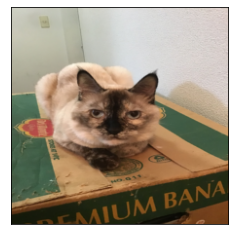

In [24]:
imshow_tensor(cat1_tensor_output[0])
imshow_tensor(cat2_tensor[0])

In [25]:
inputs = cat1_tensor.clone()
target = cat2_tensor.clone()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(100):
    optimizer.zero_grad()

    output = model(inputs)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(i, loss.item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0 0.049759477376937866
10 0.049759477376937866
20 0.049759477376937866
30 0.049759477376937866
40 0.049759477376937866
50 0.049759477376937866
60 0.049759477376937866
70 0.049759477376937866
80 0.049759477376937866
90 0.049759477376937866


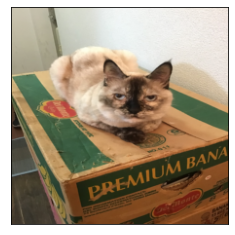

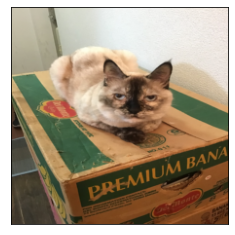

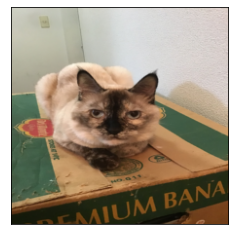

In [26]:
imshow_tensor(inputs[0])
imshow_tensor(output[0])
imshow_tensor(target[0])

## How to Apply Affine Transform by PyTorch

PyTorchではアフィン変換を`F.affine_grid`と`F.grid_sample`を使用しているが、これらの関数はそれぞれ`Tensor`クラスの関数である`affine_grid_generator`と`grid_sampler`を呼び出しており、これらの関数自体の実装はC++で行われている。

- [[C++] affine_grid_generator](https://github.com/pytorch/pytorch/blob/74b65c32be68b15dc7c9e8bb62459efbfbde33d8/aten/src/ATen/native/AffineGridGenerator.cpp#L77)
- [[C++] grid_sampler](https://github.com/pytorch/pytorch/blob/877c96cddfebee00385307f9e1b1f3b4ec72bfdc/aten/src/ATen/native/GridSampler.cpp#L429)

[Official API Docs](https://pytorch.org/cppdocs/api/library_root.html)

### [C++] affine_grid_generator

ざっくりとC++のソースコードを追っていく。なおTensorの形状チェックを行って呼び出す関数を決めている処理は不必要であるため、省いて考えていく。

なお以下では2次元画像に対しての処理を考えていく。

アフィン変換を行う流れとしては、まずは`affine_grid_generator`を使用して[-1, 1]に正規化した同次座標形式の座標情報を作成し、`reshape`を利用してアフィン変換のパラメータ $\theta$ を適用する。

```cpp
// /aten/src/ATen/native/AffineGridGenerator.cpp
Tensor affine_grid_generator(const Tensor& theta, IntArrayRef size, bool align_corners) {
  // :param Tensor: [N, C, H, W] for 2D, [N, C, D, H, W] for 3D
  // :param theta: [N, 2, 3] for 2D, [N, 3, 4] for 3D

  // Tensorが4次元か5次元であることをチェック
  // 4次元の場合
  // → [x] affine_grid_generator_4D
  // 5次元の場合
  // → [ ] affine_grid_generator_5D
}

// /aten/src/ATen/native/AffineGridGenerator.cpp
Tensor affine_grid_generator_4D(
    const Tensor& theta,
    int64_t N,
    int64_t C,
    int64_t H,
    int64_t W,
    bool align_corners) {
  // :param theta: [N, 2, 3] for 2D, [N, 3, 4] for 3D

  // base_grid: [N, H, W, 3]
  Tensor base_grid = make_base_grid_4D(theta, N, C, H, W, align_corners);
  // apply Affine Matrices
  // base_grid x theta: [N, HxW, 3] x [N, 3, 2]
  // base_gridのあるサンプルのある座標のデータの形状は[1, 1, 3]であり、幅(x)・高さ(y)・1のデータで構成される。
  // bmmでは1つの計算を見てみるとアフィン変換に対応
  // [[x, y, 1]] x [[a, c], [b, d], [tx, ty]]
  auto grid = base_grid.view({N, H * W, 3}).bmm(theta.transpose(1, 2));
  // base_grid: [N, H, W, 2]
  return grid.view({N, H, W, 2});
}

// /aten/src/ATen/native/AffineGridGenerator.cpp
Tensor make_base_grid_4D(
    const Tensor& theta,
    int64_t N,
    int64_t C,
    int64_t H,
    int64_t W,
    bool align_corners) {
  // :param theta: [N, 2, 3] for 2D, [N, 3, 4] for 3D

  // thetaと同じ型やデバイス設定で、入力テンソルに合わせてTensorを初期化する
  // base_grid: [N, H, W, 3]
  auto base_grid = at::empty({N, H, W, 3}, theta.options());

  // select(dim=-1, index=0)は[N,H,W,3]のうち最後の次元でTensorを分割して、3つに分解したうちの0番目のTensorを抽出できる。
  // x方向のグリッド(shape: [W])を[-1, 1]で計算
  // ブロードキャストでは[N, H, W]の中の[W]にグリッドをコピーして、高さ方向にブロードキャスト
  base_grid.select(-1, 0).copy_(linspace_from_neg_one(theta, W, align_corners));
  // y方向のグリッド(shape: [H, 1])を[-1, 1]で計算
  // ブロードキャストでは[N, H, W]の中の[H]にグリッドをコピーして、幅方向にブロードキャスト
  base_grid.select(-1, 1).copy_(linspace_from_neg_one(theta, H, align_corners).unsqueeze_(-1));
  // すべて1で埋める (同次座標に対応)
  base_grid.select(-1, 2).fill_(1);

  return base_grid;
}

// /aten/src/ATen/native/AffineGridGenerator.cpp
at::Tensor linspace_from_neg_one(const Tensor& grid, int64_t num_steps, 
                                 bool align_corners) {

  // :param num_steps: グリッド計算する範囲であり、画像の幅や高さを指定する
  if (num_steps <= 1) {
    return at::tensor(0, grid.options());
  }
  // グリッドを指定の幅や高さに関して、[-1, 1]の範囲で正規化を行っている。
  auto range = at::linspace(-1, 1, num_steps, grid.options());
  if (!align_corners) {
    range = range * (num_steps - 1) / num_steps;
  }
  return range;
}
```

### [C++] grid_sampler

こちらでもC++の実装をざっくり追っていく。同様にTensorの形状チェックなどの処理は省いていく。
なお実際にアフィン変換以外の処理を実装する場合には、変換後のグリッドを計算するモジュールのみを実装して、グリッドを適用する部分はそのまま本モジュールを呼び出せばいいだけなので、そこまで処理内容を深く追う必要は無い。

```cpp
// /aten/src/ATen/native/GridSampler.cpp
Tensor grid_sampler(const Tensor& input, const Tensor& grid,
                    int64_t interpolation_mode, int64_t padding_mode,
                    bool align_corners) {
  // :param input: [N, C, H, W] for 2D, [H, C, D, H, W] for 3D
  // :param grid: [N, H, W, 2] for 2D, [N, D, H, W, 3] for 3D
  // :param interpolation_mode: `bilinear` || `nearest`
  // :param padding_mode: `zeros` || `border` || `reflection`
  // :param align_corners: 
  
  // 入力Tensorとグリッドが型定義されているか検証する
  // 型定義がある場合には、Tensorの設定をコピーしておく
  auto input_opt = input.options();
  auto grid_opt = grid.options();
  // 入力Tensorとグリッドのデバイス設定が一致するか検証する
  // 入力Tensorとグリッドの型が一致するか検証する
  // 入力Tensorとグリッドのlayout(/c10/core/Layout.h)が一致するか検証する
  // 入力Tensorの形状が4次元か5次元であり、グリッドの形状が一致するか検証する
  // 入力Tensorとグリッドのバッチサイズが一致するか検証する
  // グリッドの最後の次元数が、入力Tensorが2次元であるか3次元であるか一致するか検証する
  // 入力Tensorの各次元の要素数が正値であることを検証する

  // cudnn does not support inputs larger than 1024
  if (at::native::cudnn_is_acceptable(input) &&
      at::native::cudnn_is_acceptable(grid) &&
      static_cast<GridSamplerInterpolation>(interpolation_mode) == GridSamplerInterpolation::Bilinear &&
      static_cast<GridSamplerPadding>(padding_mode) == GridSamplerPadding::Zeros &&
      align_corners &&
      input.dim() == 4 &&
      input.size(1) <= 1024) {
    return cudnn_grid_sampler(input, grid);
  }
  if (input.dim() == 4) {
    return at::grid_sampler_2d(input, grid, interpolation_mode, padding_mode, align_corners);
  } else {
    return at::grid_sampler_3d(input, grid, interpolation_mode, padding_mode, align_corners);
  }
}

// /aten/src/ATen/native/GridSampler.cpp
Tensor grid_sampler_2d_cpu(const Tensor& input, const Tensor& grid,
                           int64_t interpolation_mode, int64_t padding_mode,
                           bool align_corners) {
  // :param input: [N, C, H, W]
  // :param grid: [N, H, W, 2]

  return grid_sampler_2d_cpu_kernel(
    kCPU, input, grid, interpolation_mode, padding_mode, align_corners);
}

// /aten/src/ATen/native/cpu/GridSamplerKernel.cpp

```

## Thin-Plate Spline

以下の資料を翻訳しながら説明を進めていく。

- [Thin Plate Splines Warping Software Developer](https://khanhha.github.io/posts/Thin-Plate-Splines-Warping/)

### 画像のwarpとは

変換前の画像中の任意のピクセル点 $(x_i,y_i)$ を、$(\Delta{x_i},\Delta{y_i})$ だけ動かすように画像を歪曲させることを考える。


これは画像中のピクセル点 $(x,y)$ を歪曲させた際に、歪曲後のピクセル位置 $(x^{\prime},y^{\prime})$ が期待される投影点 $(x_i+\Delta{x_i},y_i+\Delta{y_i})$ に可能な限り近づけ、かつ他の点も平滑に歪曲させるような投影関数 $f$ を求める問題ととらえることができる。


以下の画像では、画像中で示されているピクセル位置を赤矢印の分だけずらすことを考えている。
左側の画像の歪曲前のピクセル位置を制御点 $(x_i,y_i)$ とし、制御点に対応している右側のピクセル位置を $(x_i+\Delta{x_i},y_i+\Delta{y_i})$ とする。

これらの制御点の情報から以下の画像のような変形を平滑に行う補間関数 $f$ を見つける必要がある。

![](https://khanhha.github.io/assets/images/tps/2019-10d65de0.png)

1次元で考えると、以下の画像のように赤色で示される任意の変換前後の点 $(x_i,x^{\prime})$ が与えられた場合に、これらの情報から他の地点でも変換後に対応する点を補間可能な関数 (青線) を探し出すことである。

![](https://khanhha.github.io/assets/images/tps/2019-bb55c491.png)

### RBF補間

Thin-Plate Splineに入る前に、一般系であるRBF補間の原理を説明していく。


まずは１次元を仮定して、以下の画像の赤点で示されているように、有限個の制御点が与えられている状況を考えていく。

最も単純な補間方法は、隣接する2点間の座標を線形的に補間することである。

![](https://khanhha.github.io/assets/images/tps/2019-cd769232.png)

線形補間の弱点は、制御点を通して平滑に補間することができない点である。

滑らかに補間する方法としてRBFを利用することを考える。RBFとは、値が原点からの距離にのみ依存する実数値関数である。

これで以下の画像のように、対応する制御点に近い領域では対応するKernelの影響を強くうけ、離れた制御点に対応するKernelの影響はあまりうけないような補間が行われる。

![](https://khanhha.github.io/assets/images/tps/2019-fe1ff27f.png)

補間を行う際には、任意の点はすべての制御点に対応するKernelの影響を受けているため、これをKernelの重み付け和として表現する。

つまり制御点に対応する重みを $\alpha_i$ 、RBFを $R(x,x_i)$ を表現すると、任意の点 $x$ の補間値 $x^{\prime}$ は以下のように表現できる。

$$
x^{\prime}=f(x)=\sum \alpha_{i} R\left(x, x_{i}\right)
$$

この $\alpha_i$ は、与えられた制御点に対する線形方程式の解として計算することが可能である。もしも変換前後の制御点が3点与えられていた場合 ($(x_0,x_0^{\prime}),(x_1,x_1^{\prime}),(x_2,x_2^{\prime})$) 、これらの重み付け線形和は以下の方程式で計算できる。

$$
\left[\begin{array}{c}
x_{0}^{\prime} \\
x_{1}^{\prime} \\
x_{2}^{\prime}
\end{array}\right]=\left[\begin{array}{ccc}
R\left(x_{0}, x_{0}\right) & R\left(x_{0}, x_{1}\right) & R\left(x_{0}, x_{2}\right) \\
R\left(x_{1}, x_{0}\right) & R\left(x_{1}, x_{1}\right) & R\left(x_{1}, x_{2}\right) \\
R\left(x_{2}, x_{0}\right) & R\left(x_{2}, x_{1}\right) & R\left(x_{2}, x_{2}\right)
\end{array}\right] \times\left[\begin{array}{c}
\alpha_{0} \\
\alpha_{1} \\
\alpha_{2}
\end{array}\right]
$$

この方程式の解は以下のように計算できる。

$$\vec{\alpha}=R^{-1} \times \vec{x}$$

使用するKernelにはガウシアンカーネル $\exp{(-r^2/2\sigma)}$ や、Thin-Plate Splineで使用される $r^2\log{r}$ などが存在している。

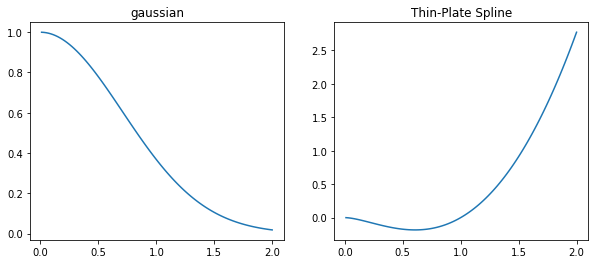

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(start=0.01, stop=2.0, num=100)
gaussian = np.exp(-(1.0*x)**2)
tps = (x**2) * np.log(x)

axes[0].plot(x, gaussian)
axes[0].set_title("gaussian")

axes[1].plot(x, tps)
axes[1].set_title("Thin-Plate Spline")

plt.show()

### Thin Plate Spline

2次元での歪曲に関するThin Plate Spline補間法を考えていく。

条件としては、赤点で示される歪曲前の制御点と青点で示される歪曲後の制御点から、左側の離散的なグリッド点を、右側のように歪曲させることを考える。

これは赤矢印で示されるx方向の変化量と、青矢印で示されるy方向の変化量を、それぞれのグリッド点で計算可能な補間関数を求めることと同じである。

![](https://khanhha.github.io/assets/images/tps/2019-d278d8c0.png)

Thin Plate Splineを提案している論文では、以下のように歪曲前のグリッド点を、グリッド点の線形和と任意の数の制御点の重み付き線形和で表現している。

$$
f_{x^{\prime}}(x, y)=a_{1}+a_{x} x+a_{y} y+\sum_{i=1}^{N} w_{i} U\left(\left\|\left(x_{i}, y_{i}\right)-(x, y)\right\|\right)
$$

$$
f_{y^{\prime}}(x, y)=a_{1}+a_{x} x+a_{y} y+\sum_{i=1}^{N} w_{i} U\left(\left\|\left(x_{i}, y_{i}\right)-(x, y)\right\|\right)
$$

以下の画像は、歪曲前後の点に対応する変化量 $(\Delta_{x},\Delta_{y})$ を高さとして表現しているものである。

![](https://khanhha.github.io/assets/images/tps/2019-4b0c6ba8.png)

式中の以下の式は、計算対称のグリッド点と制御点の距離で表現される関数であり、 $U(r)=r^2\log{r}$ が使用されている。

$$
U\left(\left\|\left(\left(x_{i}, y_{i}\right)-(x, y)\right)\right\|\right)
$$

以下の画像はこの関数の値を可視化したものであり、制御点に理解ほどより大きな値が計算されていることが分かる。

![](https://khanhha.github.io/assets/images/tps/2019-8076195d.png)

以下の画像は複数の制御点から計算した値を示している。

![](https://khanhha.github.io/assets/images/tps/2019-18b0ca24.png)

グリッド点の線形和に使用する係数 $(a,a_x,a_y)$ と、Kernelの重み付け線形和で使用する係数 $(w_i)$ は以下の線型方程式を解くことで得られる。なお行列 $K_{ij}$ は、各制御点に対応するKernel関数の値で構成されており、行列 $P$ は、制御点の同次座標 $(1,x_i,y_i)$ になる。

$$
L=\left[\begin{array}{ll}
K & P \\
P^{T} & O
\end{array}\right] \times\left[\begin{array}{l}
w \\
a
\end{array}\right]=\left[\begin{array}{l}
v \\
o
\end{array}\right]
$$

この方程式の1行目の式 $[K P]\times [w,a]^{T}$ は関数 $f_{x^{\prime}},f_{y^{\prime}}$ を表現しており、2行目の式 $[P^T O]\times [w,a]^T$ は元論文で提案されている以下の制約を加えることに対応する。

$$
\sum_{i=1}^{N} w_{i}=0 \tag{1}
$$

$$
\sum_{i=1}^{N} w_{i} x_{i}=\sum_{i=1}^{N} w_{i}y_{i}=0 \tag{2}
$$

具体的な形式の例を考えると、3つの制御点が与えられた場合には、TPS補間を行う関数はx方向とy方向でそれぞれ以下の方程式で計算できる。

$$
\left[\begin{array}{cccccc}
K_{00} & K_{10} & K_{20} & 1 & x_{0} & y_{0} \\
K_{01} & K_{11} & K_{21} & 1 & x_{1} & y_{1} \\
K_{02} & K_{12} & K_{22} & 1 & x_{2} & y_{2} \\
1 & 1 & 1 & 0 & 0 & 0 \\
x_{0} & x_{1} & x_{2} & 0 & 0 & 0 \\
y_{0} & y_{1} & y_{2} & 0 & 0 & 0
\end{array}\right] \times\left[\begin{array}{c}
w_{0} \\
w_{1} \\
w_{2} \\
a_{0} \\
a_{x} \\
a_{y}
\end{array}\right]=\left[\begin{array}{c}
x_{0}^{\prime} \\
x_{1}^{\prime} \\
x_{2}^{\prime} \\
0 \\
0 \\
0
\end{array}\right]
$$

$$
\left[\begin{array}{cccccc}
K_{00} & K_{10} & K_{20} & 1 & x_{0} & y_{0} \\
K_{01} & K_{11} & K_{21} & 1 & x_{1} & y_{1} \\
K_{02} & K_{12} & K_{22} & 1 & x_{2} & y_{2} \\
1 & 1 & 1 & 0 & 0 & 0 \\
x_{0} & x_{1} & x_{2} & 0 & 0 & 0 \\
y_{0} & y_{1} & y_{2} & 0 & 0 & 0
\end{array}\right] \times\left[\begin{array}{c}
w_{0} \\
w_{1} \\
w_{2} \\
a_{0} \\
a_{x} \\
a_{y}
\end{array}\right]=\left[\begin{array}{c}
y_{0}^{\prime} \\
y_{1}^{\prime} \\
y_{2}^{\prime} \\
0 \\
0 \\
0
\end{array}\right]
$$

### 参考文献

- [Thin Plate Splines Warping](https://khanhha.github.io/posts/Thin-Plate-Splines-Warping/)
- [OpenCV3 Thin Plate Splineの使い方](https://qiita.com/SousukeShimoyama/items/2bf8defb2d057bb8b742)
- [Manual Registration with Thin Plates](https://profs.etsmtl.ca/hlombaert/thinplates/)
- [Radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function)
- [Radial basis function interpolation](https://en.wikipedia.org/wiki/Radial_basis_function_interpolation)
- [放射基底関数（Radial basis function, RBF）](http://zellij.hatenablog.com/entry/20121018/p1)
- [動径基底関数（RBF）に関連する知識の整理](https://mathwords.net/doukeikitei)
- [RBF 補間 (Radial Basis Function Interpolation) の概要と実装](http://yuki-koyama.hatenablog.com/entry/2014/05/04/132552)

## Implementation

以下の記事を翻訳しながら理解を進めていく

- [Image-Based Virtual Try On Network - Part 1](https://khanhha.github.io/posts/Image-based-Virtual-Try-On-Network-Part-1/)
- [https://github.com/cheind/py-thin-plate-spline](https://github.com/cheind/py-thin-plate-spline)

条件としては、変換前後の制御点の組み合わせからTPS補間を行うことを考える。

これは左側のように初期値として与えたグリッド点と、Neural Networkを使用して推論した右側のような制御点からTPS補間を実行することで達成していく。

![](https://khanhha.github.io/assets/images/vton/2019-59c2eeda.png)

まずは初期化の段階で、制御点となる位置を用意する。

In [28]:
# 画像のサイズを確認する
n, _, h, w = cat1_tensor.shape

print(n, h, w)

1 224 224


画像に従ってグリッド状に制御点をサンプリングする。

In [29]:
# 制御点をグリッド状に配置する。
def uniform_grid(grid_shape):

    h, w = grid_shape
    c = torch.zeros(h, w, 2)
    # [h, w]に幅方向の[w,]を代入することで、高さ方向にブロードキャストされる
    c[..., 0] = torch.linspace(-1, 1, w)
    # [h, w]に高さ方向の[h, 1]を代入することで、幅方向にブロードキャストされる
    c[..., 1] = torch.linspace(-1, 1, h).unsqueeze(-1)
    return c.view(-1, 2)

input_control_points = uniform_grid((4, 4))

print(input_control_points.shape)

torch.Size([16, 2])


制御点の初期化を実行したため、次に関数の計算に必要な係数の初期化を行う。係数は以下の式に従って、制御点の数＋3個のパラメータが、xとyの2つ分で構成されている。

$$
f_{x^{\prime}}(x, y)=a_{1}+a_{x} x+a_{y} y+\sum_{i=1}^{N} w_{i} U\left(\left\|\left(x_{i}, y_{i}\right)-(x, y)\right\|\right)
$$

なおPyTorchで実装するため、バッチサイズ分の次元が余計に必要となる。

In [30]:
num_input_control_points = input_control_points.shape[0]

print(num_input_control_points)

16


$$
\theta=[w_1,\cdots,w_N,a,a_x,a_y]^T
$$

In [31]:
# theta: [Batchsize, #control_points+linear_coefficient, x_and_y]
theta = torch.zeros(n, num_input_control_points + 3, 2)

print(theta.shape)

torch.Size([1, 19, 2])


次にアフィン変換のときと同様に`F.grid_sample`に渡せるように、入力する画像テンソルに対応するグリッド点を計算していく。

In [32]:
def linspace_from_neg_one(theta, num_steps, align_corners):

    if (num_steps <= 1):
        return theta.new_tensor(0)

    range = torch.linspace(-1, 1, num_steps, dtype=theta.dtype, device=theta.device)

    if (not align_corners):
        range = range * (num_steps - 1) / num_steps

    return range

In [33]:
# グリッドの初期化
# グリッドの値は[-1, 1]の範囲で正規化する必要がある。

def make_base_grid(theta, size, align_corners=False):

    N, _, H, W = size
    # 同次座標形式でグリッドを初期化する
    grid = theta.new(N, H, W, 3)
    grid.select(dim=-1, index=0).fill_(1.)
    grid.select(dim=-1, index=1).copy_(linspace_from_neg_one(theta, W, align_corners))
    grid.select(dim=-1, index=2).copy_(linspace_from_neg_one(theta, H, align_corners).unsqueeze(-1))
    
    return grid

grid = make_base_grid(theta, (1, 3, 224, 224))

print(grid.shape)

torch.Size([1, 224, 224, 3])


次に制御点とパラメータを使用して、用意しているグリッドを歪曲させる。

In [34]:
def tps(theta, control_points, grid, eps=1e-6):
    """
    :param theta: shape of [N, T+3, 2]
    :param control_points: shape of [(H_p x W_p), 2]
    :param grid: shape of [N, H, W, 3]
    """

    # grid shape
    N, H_g, W_g, _ = grid.size()
    # control_points shaepe
    HW_p, _ = control_points.shape

    # expand control points to batch dimension
    control_points = control_points.view(1, HW_p, -1).expand(N, *control_points.shape)

    # distance between grid_points      and control_points
    #                  [N, H_g, W_g, 3]     [N, (H_p x W_p), 2]
    # calculate all pair distances between ((H_g x W_g) and (H_p x W_p))
    distance = grid[..., 1:].view (N, H_g, W_g, 1,    2) - \
               control_points.view(N, 1,   1,   HW_p, 2)
    # calculate distance from summation of x and y
    distance = torch.sqrt((distance**2).sum(-1))
    # U(r) = r^2 * log(r)
    # U: [N, H_g, W_g, HW_p]
    U = (distance**2) * torch.log(distance + eps)

    w, a = theta[:, :-3, :], theta[:, -3:, :]

    # calculate weighted linear combination of U and w
    # [N, H_g, W_g, HW_p] x [N, HW_p, 2] --> [N, H_g, W_g, 2]
    kernel_term = torch.einsum("ijkl,ilm->ijkm", U, w)
    # calculate linear combination of P and a
    # [N, H_g, W_g, 3] x [N, 3, 2] --> [N, H_g, W_g, 2]
    linear_term = torch.einsum("ijkl,ilm->ijkm", grid, a)

    delta_xy = linear_term + kernel_term

    return delta_xy

これでx方向とy方向に対する、元のグリッド点からの変化量を計算することができたため、最初に計算した元のグリッド点の座標に変化量を足せばいい。

なお現状では全パラメータを0で初期化しているため、変化量も0で計算される。

In [35]:
delta_xy = tps(theta, input_control_points, grid)

print(delta_xy.shape)
print(delta_xy.min(), delta_xy.max())

torch.Size([1, 224, 224, 2])
tensor(0.) tensor(0.)


これまでの計算の流れをまとめると以下になる。

1. 制御点をグリッド状に計算
    - 形状
2. TPSのパラメータを設定
3. 画像と同じ幅と高さを有するグリッドを計算
4. TPSの計算を行いx方向とy方向の変化量を計算
    - パラメータ
    - 制御点
    - グリッド

後はこの処理を、`F.affine_grid`と同様のAPIとしてまとめればいい。

### tps_grid

In [36]:
def tps_grid(theta, size, control_points, align_corners=False):
    r"""
    Generates a 2D flow field (sampling grid), given a batch of
    affine matrices :attr:`theta` and control points :attr:`control_points`.

    .. note::
        This function is often used in conjunction with :func:`grid_sample`.

    Args:
        theta (Tensor): input batch of tps parameters with number of control points T
             with shape [N, T+3, 2] 
        size (torch.Size): the target output image size with shape [N, C, H, W]
        control_points (Tensor): input batch of control points with number of
             control points T with shape [N, T, 2]
        align_corners (bool, optional): if ``True``, consider ``-1`` and ``1``
            to refer to the centers of the corner pixels rather than the image corners.
            Refer to :func:`grid_sample` for a more complete description.
            A grid generated by :func:`affine_grid` should be passed to :func:`grid_sample`
            with the same setting for this option.
            Default: ``False``

    Returns:
        output (Tensor): output Tensor of size [N, H, W, 2]
    """

    grid = make_base_grid(theta, size, align_corners)
    delta_xy = tps(theta, control_points, grid)

    return grid[..., 1:] + delta_xy

In [37]:
grid_height = 4
grid_width  = 4
num_input_control_points = grid_height * grid_width

theta = torch.zeros(n, num_input_control_points + 3, 2)
size = cat1_tensor.shape
input_control_points = uniform_grid((4, 4))

grid = tps_grid(theta, size, input_control_points)

In [38]:
cat1_tensor_tps = F.grid_sample(cat1_tensor, grid, mode="nearest")

print(cat1_tensor_tps.shape)
print(cat1_tensor_tps.dtype)
print(cat1_tensor_tps.min(), cat1_tensor_tps.max())

torch.Size([1, 3, 224, 224])
torch.float32
tensor(0.0039) tensor(1.)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


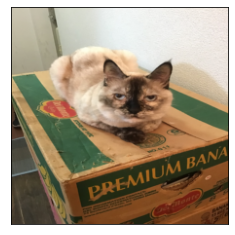

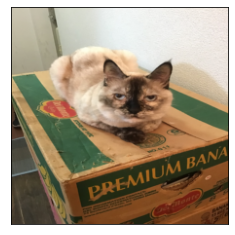

In [39]:
imshow_tensor(cat1_tensor[0])
imshow_tensor(cat1_tensor_tps[0])

### 参考文献

- [https://github.com/cheind/py-thin-plate-spline](https://github.com/cheind/py-thin-plate-spline)

## Optimize TPS Parameters

In [40]:
class TPSNet(nn.Module):
    def __init__(self, grid_height, grid_width, mode='bilinear'):
        super().__init__()
        self.grid_height = grid_height
        self.grid_width = grid_width
        self.mode = mode

        self.num_control_points = grid_height * grid_width
        self.nparams = self.num_control_points + 3
        self.control_points = uniform_grid((grid_height, grid_width))

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(20, 30, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(30, 40, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(40 * 14 * 14, 32),
            nn.ReLU(True),
            nn.Linear(32, self.nparams * 2, bias=False)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 40 * 14 * 14)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, self.num_control_points + 3, 2)

        grid = tps_grid(theta, x.size(), self.control_points)
        x = F.grid_sample(x, grid, mode=self.mode)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        return x

In [41]:
model = TPSNet(grid_height=4, grid_width=4, mode="nearest")

In [42]:
apply_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [43]:
cat1_tensor = apply_transforms(Image.fromarray(cat1)).unsqueeze(0)
cat2_tensor = apply_transforms(Image.fromarray(cat2)).unsqueeze(0)

print(cat1_tensor.shape)
print(cat1_tensor.dtype)
print(cat1_tensor.min(), cat1_tensor.max())

torch.Size([1, 3, 224, 224])
torch.float32
tensor(0.0039) tensor(1.)


In [44]:
# identity transform before training
cat1_tensor_output = model(cat1_tensor)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


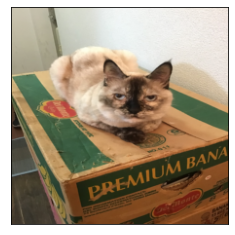

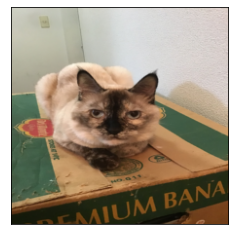

In [45]:
imshow_tensor(cat1_tensor_output[0])
imshow_tensor(cat2_tensor[0])

In [46]:
inputs = cat1_tensor.clone()
target = cat2_tensor.clone()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(100):
    optimizer.zero_grad()

    output = model(inputs)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(i, loss.item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0 0.049759477376937866
10 0.049759477376937866
20 0.049759477376937866
30 0.049759477376937866
40 0.049759477376937866
50 0.049759477376937866
60 0.049759477376937866
70 0.049759477376937866
80 0.049759477376937866
90 0.049759477376937866


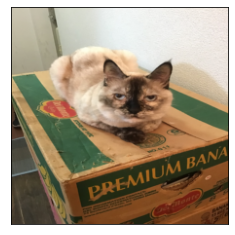

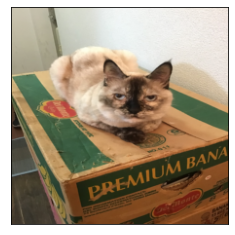

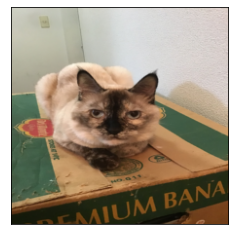

In [47]:
imshow_tensor(inputs[0])
imshow_tensor(output[0])
imshow_tensor(target[0])